In [146]:
from argparse import ArgumentParser
import h5py
from itertools import permutations
from pathlib import Path
from typing import cast, Optional, List, Tuple, Dict, Type, TypeVar, Sequence
from tqdm import tqdm
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from cropharvest.datasets import CropHarvest, CropHarvestLabels, Task
from cropharvest.columns import NullableColumns, RequiredColumns
from cropharvest.config import FEATURES_DIR
from cropharvest.engineer import Engineer
from cropharvest.utils import load_normalizing_dict
from cropharvest.bands import BANDS, DYNAMIC_BANDS, STATIC_BANDS, REMOVED_BANDS

sys.path.append("..")

from src.models import STR2MODEL, STR2BASE, train_model


S2_BANDS = ['B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','NDVI']

In [2]:
DATA_DIR = "../data/cropharvest"

In [3]:
# This will download all geowiki data
evaluation_datasets = CropHarvest.create_benchmark_datasets(DATA_DIR)

## Get geowiki data

- Load all labels and get all h5 files paths
- Recalculate normalizing dict
- Get as array

In [58]:
# Make parent CropHarvest base class
class BaseCropHarvestDataset():
    root: Path
    filepaths: List
    y_vals: List

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index: int):
        file = h5py.File(self.filepaths[index], "r")
        return self._normalize(file.get("array")[:]), self.y_vals[index]
    
    def as_array(self, flatten_x=False, S2_features_only=False):
        indices_to_sample = list(range(len(self)))
        X, Y = zip(*[self[i] for i in indices_to_sample])
        X_np, y_np = np.stack(X), np.stack(Y)
        if S2_features_only:
            indices = [BANDS.index(band) for band in S2_BANDS]
            X_np = np.take(X_np, indices, axis=2)
        if flatten_x:
            X_np = self._flatten_array(X_np)
        return X_np, y_np

    def _path_from_row(self, row):
        path = self.root / f"features/arrays/{row[RequiredColumns.INDEX]}_{row[RequiredColumns.DATASET]}.h5"
        if not path.exists():
            return None
        return path

    def _discard_missing_files(self):
        self.labels['path'] = self.labels.apply(lambda row: self._path_from_row(row), axis=1)
        self.labels = self.labels[~self.labels['path'].isna()].reset_index(drop=True)
        
    def _normalize(self, array):
        if not self.normalizing_dict:
            return array
        return (array - self.normalizing_dict["mean"]) / self.normalizing_dict["std"]
            
    @staticmethod
    def _flatten_array(array):
        return array.reshape(array.shape[0], -1)
    

In [59]:
# GeowikiCropHarvest = TypeVar('GeowikiCropHarvest', bound='Parent') # for typing

# class GeowikiCropHarvest:
#     def __init__(self, root="data",
#                 countries_subset = Optional[List[str]],
#                 labels: Optional[pd.DataFrame] = None, # if this is passed csv_file will be ignored
#                 normalizing_dict: Optional[Dict] = None,
#                 ) -> None:    
#         self.root = Path(root)
#         self.countries_subset = countries_subset

#         # Labels
#         if labels is None:
#             cropharvest_labels = CropHarvestLabels(root, download=True)
#             cropharvest_df = cropharvest_labels.as_geojson()
#             self.labels = cropharvest_df[cropharvest_df['dataset'] == 'geowiki-landcover-2017'].reset_index(drop=True)
#             self.labels = self._add_country()
#             self._discard_missing_files() # only around 24761/35866 geowiki files come with cropharvest
#             # Country subset
#             if self.countries_subset:
#                 self.labels = self.labels[self.labels.country.str.lower().isin(list(map(str.lower, self.countries_subset)))]
#         else: # Comes from split
#             self.labels = labels

#         self.filepaths = self.labels['path'].tolist()
#         self.y_vals = self.labels['is_crop'].tolist()
#         if normalizing_dict is None:
#             self.normalizing_dict = self.get_normalizing_dict()
#         else:
#             self.normalizing_dict = normalizing_dict  

#     def __len__(self):
#         return len(self.filepaths)

#     def __getitem__(self, index: int):
#         file = h5py.File(self.filepaths[index], "r")
#         return self._normalize(file.get("array")[:]), self.y_vals[index]
    
#     def as_array(self, flatten_x=False):
#         indices_to_sample = list(range(len(self)))
#         X, Y = zip(*[self[i] for i in indices_to_sample])
#         X_np, y_np = np.stack(X), np.stack(Y)
#         if flatten_x:
#             X_np = self._flatten_array(X_np)
#         return X_np, y_np

#     def _path_from_row(self, row):
#         path = self.root / f"features/arrays/{row[RequiredColumns.INDEX]}_{row[RequiredColumns.DATASET]}.h5"
#         if not path.exists():
#             return None
#         return path

#     def _add_country(self):
#         world_map = gpd.read_file('../assets/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp') # TODO: maybe move to utils to access from different places with a fixed path to assets
#         labels = self.labels.copy()
#         join_df = gpd.sjoin(labels, world_map, how='left', op="within")[['index', 'ADMIN']] # spatial merge and keep only necessary columns
#         new_labels = pd.merge(labels, join_df, on='index', how='left')
#         new_labels.rename(columns={'ADMIN': 'country'}, inplace=True)
#         new_labels.loc[new_labels.country.isnull(), 'country'] = 'unknown' # convert NaN country entries to strings
#         return new_labels

#     def _discard_missing_files(self):
#         self.labels['path'] = self.labels.apply(lambda row: self._path_from_row(row), axis=1)
#         self.labels = self.labels[~self.labels['path'].isna()].reset_index(drop=True)
        
#     def _search_normalizing_dict(self, default_file_name: str="geowiki_normalizing_dict.h5") -> Optional[Path]:
#         '''Searches for the normalizing dict file in the self.data_dir directory and returns its path. Returns None if it was not found.'''
#         prefix = default_file_name.split('.')[0]
#         file_path = self.root / FEATURES_DIR / default_file_name
#         if not self.countries_subset:
#             if file_path.exists():
#                 print(f'Found normalizing dict {file_path.name}')
#                 return file_path
#         elif len(self.countries_subset) == 1 and self.countries_subset[0].lower() == 'africa':
#             raise NotImplementedError # TODO
#         else:
#             assert len(self.countries_subset) < 10, 'Execution time will be too big!' # TODO: add warning when passing subset to constructor
#             countries_permutations = list(permutations(self.countries_subset))
#             countries_permutations = ['_'.join(permutation) for permutation in countries_permutations]
#             for permutation in countries_permutations:
#                 file_name = f"{prefix}_{permutation}.h5"
#                 file_path = file_path.parent / file_name
#                 if file_path.exists():
#                     print(f'Found normalizing dict {file_name}')
#                     return file_path
#         print('Normalizing dict not found.')
#         return None

#     def get_normalizing_dict(self, save: bool=True):
#         nd_name = "geowiki_normalizing_dict.h5"
#         nd_path = self._search_normalizing_dict(nd_name)
#         if nd_path:
#             print(f'Loading normalizing dict {nd_path}')
#             normalizing_dict = load_normalizing_dict(nd_path)
#         else:
#             print('Calculating normalizing dict')
#             geowiki_engineer = Engineer(self.root)
#             for file_path in tqdm(self.filepaths):
#                 with h5py.File(file_path, "r") as file:
#                     array = file.get("array")[:]
#                 geowiki_engineer.update_normalizing_values(array)

#             normalizing_dict = geowiki_engineer.calculate_normalizing_dict()

#             # Write file
#             if save and normalizing_dict is not None:
#                 if self.countries_subset: # modify nd file name
#                     prefix = nd_name.split('.')[0]
#                     countries_str = '_'.join(self.countries_subset)
#                     nd_name = f"{prefix}_{countries_str}.h5"
#                 nd_path = self.root / FEATURES_DIR / nd_name
#                 print('Saving normalizing dict', nd_path.name)
#                 hf = h5py.File(nd_path, "w")
#                 for key, val in normalizing_dict.items():
#                     hf.create_dataset(key, data=val)
#                 hf.close()
            
#         return normalizing_dict

#     def _normalize(self, array):
#         if not self.normalizing_dict:
#             return array
#         return (array - self.normalizing_dict["mean"]) / self.normalizing_dict["std"]
            
#     @staticmethod
#     def _flatten_array(array):
#         return array.reshape(array.shape[0], -1)
    
#     @classmethod
#     def train_val_split(cls: Type[GeowikiCropHarvest], class_instance: Type[GeowikiCropHarvest],
#                         train_size: float=0.8, stratify_column: Optional[str]=None
#                         ) -> Tuple[GeowikiCropHarvest]:
#         # Made it a class method to be able to generate two child instances of the class.
#         # Haven't figured out a better way for now than passing the parent instance as an argument.

#         # Split labels dataframe
#         stratify = None if not stratify_column else class_instance.labels[stratify_column] # Could stratify on label crop or no-crop but it doesn't make a big difference
#         df_train, df_val = train_test_split(class_instance.labels, train_size=train_size, stratify=stratify, random_state=42)
#         df_train.reset_index(drop=True, inplace=True) 
#         df_val.reset_index(drop=True, inplace=True)

#         # Create two new GeowikiDataset instances (train and val)
#         print('Train split')
#         train_dataset = cls(root=class_instance.root, labels=df_train,
#                         normalizing_dict=class_instance.normalizing_dict)
#         print('Val split')
#         val_dataset = cls(root=class_instance.root, labels=df_val,
#                         normalizing_dict=class_instance.normalizing_dict)
#         return train_dataset, val_dataset

# #countries_subset = ['Ghana', 'Togo', 'Nigeria', 'Cameroon', 'Benin']
# #countries_subset = ['Nigeria']
# countries_subset = None
# dataset = GeowikiCropHarvest(DATA_DIR, countries_subset)    

In [109]:
GeowikiCropHarvestDataset = TypeVar('GeowikiCropHarvestDataset', bound='Parent') # for typing

class GeowikiCropHarvestDataset(BaseCropHarvestDataset):
    def __init__(self, root,
                countries_subset = Optional[List[str]],
                labels: Optional[pd.DataFrame] = None, # if this is passed csv_file will be ignored
                normalizing_dict: Optional[Dict] = None,
                ) -> None:
            
        self.root = Path(root)
        self.countries_subset = countries_subset

        # Labels
        if labels is None:
            cropharvest_labels = CropHarvestLabels(root, download=True)
            cropharvest_df = cropharvest_labels.as_geojson()
            self.labels = cropharvest_df[cropharvest_df['dataset'] == 'geowiki-landcover-2017'].reset_index(drop=True)
            self.labels = self._add_country()
            self._discard_missing_files() # only around 24761/35866 geowiki files come with cropharvest
            # Country subset
            if self.countries_subset:
                self.labels = self.labels[self.labels.country.str.lower().isin(list(map(str.lower, self.countries_subset)))]
        else: # Comes from split
            self.labels = labels

        self.filepaths = self.labels['path'].tolist()
        self.y_vals = self.labels['is_crop'].tolist()
        if normalizing_dict is None:
            self.normalizing_dict = self.get_normalizing_dict()
        else:
            self.normalizing_dict = normalizing_dict  

    def _add_country(self):
        world_map = gpd.read_file('../assets/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp') # TODO: maybe move to utils to access from different places with a fixed path to assets
        labels = self.labels.copy()
        join_df = gpd.sjoin(labels, world_map, how='left', op="within")[['index', 'ADMIN']] # spatial merge and keep only necessary columns
        new_labels = pd.merge(labels, join_df, on='index', how='left')
        new_labels.rename(columns={'ADMIN': 'country'}, inplace=True)
        new_labels.loc[new_labels.country.isnull(), 'country'] = 'unknown' # convert NaN country entries to strings
        return new_labels
        
    def _search_normalizing_dict(self, default_file_name: str="geowiki_normalizing_dict.h5") -> Optional[Path]:
        '''Searches for the normalizing dict file in the self.data_dir directory and returns its path. Returns None if it was not found.'''
        prefix = default_file_name.split('.')[0]
        file_path = self.root / FEATURES_DIR / default_file_name
        if not self.countries_subset:
            if file_path.exists():
                print(f'Found normalizing dict {file_path.name}')
                return file_path
        elif len(self.countries_subset) == 1 and self.countries_subset[0].lower() == 'africa':
            raise NotImplementedError # TODO
        else:
            assert len(self.countries_subset) < 10, 'Execution time will be too big!' # TODO: add warning when passing subset to constructor
            countries_permutations = list(permutations(self.countries_subset))
            countries_permutations = ['_'.join(permutation) for permutation in countries_permutations]
            for permutation in countries_permutations:
                file_name = f"{prefix}_{permutation}.h5"
                file_path = file_path.parent / file_name
                if file_path.exists():
                    print(f'Found normalizing dict {file_name}')
                    return file_path
        print('Normalizing dict not found.')
        return None

    def get_normalizing_dict(self, save: bool=True):
        nd_name = "geowiki_normalizing_dict.h5"
        nd_path = self._search_normalizing_dict(nd_name)
        if nd_path:
            print(f'Loading normalizing dict {nd_path}')
            normalizing_dict = load_normalizing_dict(nd_path)
        else:
            print('Calculating normalizing dict')
            geowiki_engineer = Engineer(self.root)
            for file_path in tqdm(self.filepaths):
                with h5py.File(file_path, "r") as file:
                    array = file.get("array")[:]
                geowiki_engineer.update_normalizing_values(array)

            normalizing_dict = geowiki_engineer.calculate_normalizing_dict()

            # Write file
            if save and normalizing_dict is not None:
                if self.countries_subset: # modify nd file name
                    prefix = nd_name.split('.')[0]
                    countries_str = '_'.join(self.countries_subset)
                    nd_name = f"{prefix}_{countries_str}.h5"
                nd_path = self.root / FEATURES_DIR / nd_name
                print('Saving normalizing dict', nd_path.name)
                hf = h5py.File(nd_path, "w")
                for key, val in normalizing_dict.items():
                    hf.create_dataset(key, data=val)
                hf.close()
            
        return normalizing_dict
    
    @classmethod
    def train_val_split(cls: Type[GeowikiCropHarvestDataset], class_instance: Type[GeowikiCropHarvestDataset],
                        train_size: float=0.8, stratify_column: Optional[str]=None
                        ) -> Tuple[GeowikiCropHarvestDataset]:
        # Made it a class method to be able to generate two child instances of the class.
        # Haven't figured out a better way for now than passing the parent instance as an argument.

        # Split labels dataframe
        stratify = None if not stratify_column else class_instance.labels[stratify_column] # Could stratify on label crop or no-crop but it doesn't make a big difference
        df_train, df_val = train_test_split(class_instance.labels, train_size=train_size, stratify=stratify, random_state=42)
        df_train.reset_index(drop=True, inplace=True) 
        df_val.reset_index(drop=True, inplace=True)

        # Create two new GeowikiDataset instances (train and val)
        print('Train split')
        train_dataset = cls(root=class_instance.root, labels=df_train,
                        normalizing_dict=class_instance.normalizing_dict)
        print('Val split')
        val_dataset = cls(root=class_instance.root, labels=df_val,
                        normalizing_dict=class_instance.normalizing_dict)
        return train_dataset, val_dataset

countries_subset = ['Ghana', 'Togo', 'Nigeria', 'Cameroon', 'Benin']
countries_subset = ['Nigeria']
countries_subset = None
dataset = GeowikiCropHarvestDataset(DATA_DIR, countries_subset)    

Found normalizing dict geowiki_normalizing_dict.h5
Loading normalizing dict ../data/cropharvest/features/geowiki_normalizing_dict.h5


In [110]:
train_dataset, val_dataset = dataset.train_val_split(dataset)

Train split
Val split


In [111]:
len(train_dataset.labels) + len(val_dataset.labels) == len(dataset)

True

In [113]:
#'geowiki-landcover' in str(dataset.filepaths[0])
filepath = dataset.filepaths[0]
identifier, dataset_name = filepath.stem.split('_')
identifier, dataset_name

('0', 'geowiki-landcover-2017')

In [116]:
str(filepath)

'../data/cropharvest/features/arrays/0_geowiki-landcover-2017.h5'

In [145]:
df = dataset.labels
row = df.loc[df['index'] == int(identifier)]
assert len(row) == 1 # should be unique
lat = row.iloc[0]['lat']
lon = row.iloc[0]['lon']


In [124]:
dataset.labels

,harvest_date,planting_date,label,classification_label,index,is_crop,lat,lon,dataset,collection_date,export_end_date,externally_contributed_dataset,is_test,geometry,country,path
0,None,None,None,None,0,0,-16.547619,46.250000,geowiki-landcover-2017,2016-09-30T00:00:00,2017-02-01T00:00:00,False,False,POINT (46.25000 -16.54762),Madagascar,../data/cropharvest/features/arrays/0_geowiki-...
1,None,None,None,None,1,1,-18.547619,48.250000,geowiki-landcover-2017,2016-09-30T00:00:00,2017-02-01T00:00:00,False,False,POINT (48.25000 -18.54762),Madagascar,../data/cropharvest/features/arrays/1_geowiki-...
2,None,None,None,None,2,0,-21.547619,44.250000,geowiki-landcover-2017,2016-09-30T00:00:00,2017-02-01T00:00:00,False,False,POINT (44.25000 -21.54762),Madagascar,../data/cropharvest/features/arrays/2_geowiki-...
3,None,None,None,None,3,1,-17.547619,45.250000,geowiki-landcover-2017,2016-09-30T00:00:00,2017-02-01T00:00:00,False,False,POINT (45.25000 -17.54762),Madagascar,../data/cropharvest/features/arrays/3_geowiki-...
4,None,None,None,None,4,0,-21.547619,46.250000,geowiki-landcover-2017,2016-09-30T00:00:00,2017-02-01T00:00:00,False,False,POINT (46.25000 -21.54762),Madagascar,../data/cropharvest/features/arrays/4_geowiki-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24756,None,None,None,None,35849,1,16.651786,103.550595,geowiki-landcover-2017,2016-09-30T00:00:00,2017-02-01T00:00:00,False,False,POINT (103.55060 16.65179),Thailand,../data/cropharvest/features/arrays/35849_geow...
24757,None,None,None,None,35850,1,22.651786,84.550595,geowiki-landcover-2017,2016-09-30T00:00:00,2017-02-01T00:00:00,False,False,POINT (84.55060 22.65179),India,../data/cropharvest/features/arrays/35850_geow...
24758,None,None,None,None,35851,1,10.651786,76.550595,geowiki-landcover-2017,2016-09-30T00:00:00,2017-02-01T00:00:00,False,False,POINT (76.55060 10.65179),India,../data/cropharvest/features/arrays/35851_geow...
24759,None,None,None,None,35860,0,-0.348214,36.550595,geowiki-landcover-2017,2016-09-30T00:00:00,2017-02-01T00:00:00,False,False,POINT (36.55060 -0.34821),Kenya,../data/cropharvest/features/arrays/35860_geow...


In [65]:
X, y = dataset.as_array(flatten_x=False)
X_flat, y_flat = dataset.as_array(flatten_x=True)

In [66]:
print(X.shape, y.shape)
X_flat.shape, y_flat.shape

(24761, 12, 18) (24761,)


((24761, 216), (24761,))

## Get Nigeria data

In [67]:
data_root = Path('../data/features/nigeria-cropharvest')
file_name = 'labels.geojson'

In [68]:
gdf = gpd.read_file(data_root / file_name)
gdf

,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,export_identifier,is_test,label,geometry
0,0,13.062977,7.169715,0,0,validation,2019-04-03,2020-03-28,2020-03-28,nigeria,0_nigeria_2019-04-03_2020-03-28,False,None,POINT (7.16971 13.06298)
1,0,9.861582,5.029259,1,1,training,2019-04-03,2020-03-28,2020-03-28,nigeria,1_nigeria_2019-04-03_2020-03-28,False,None,POINT (5.02926 9.86158)
2,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,2_nigeria_2019-04-03_2020-03-28,True,None,POINT (11.67388 10.44224)
3,0,6.506252,6.584187,3,3,training,2019-04-03,2020-03-28,2020-03-28,nigeria,3_nigeria_2019-04-03_2020-03-28,False,None,POINT (6.58419 6.50625)
4,0,7.980531,7.099293,4,4,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,4_nigeria_2019-04-03_2020-03-28,True,None,POINT (7.09929 7.98053)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,0,11.505429,6.910431,1822,1822,validation,2019-04-03,2020-03-28,2020-03-28,nigeria,1822_nigeria_2019-04-03_2020-03-28,False,None,POINT (6.91043 11.50543)
1823,0,13.281881,13.412151,1823,1823,validation,2019-04-03,2020-03-28,2020-03-28,nigeria,1823_nigeria_2019-04-03_2020-03-28,False,None,POINT (13.41215 13.28188)
1824,0,8.912081,3.703954,1824,1824,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1824_nigeria_2019-04-03_2020-03-28,True,None,POINT (3.70395 8.91208)
1825,1,8.653739,4.971758,1825,1825,validation,2019-04-03,2020-03-28,2020-03-28,nigeria,1825_nigeria_2019-04-03_2020-03-28,False,None,POINT (4.97176 8.65374)


In [69]:
# class NigeriaDataset():
#     def __init__(self, root='../data/features/nigeria-cropharvest', split='testing'):    
#         self.root = Path(root)
#         self._labels = CropHarvestLabels(self.root).as_geojson()
#         # Slice per subset
#         assert split in ["training", "validation", "testing"], 'Split must be either "training", "validation" or "testing".'
#         self.labels = self._labels[self._labels['new_set'] == split].reset_index()
#         self._discard_missing_files()  
#         self.filepaths = self.labels['path'].tolist()
#         self.y_vals = self.labels['is_crop'].tolist()
#         self.normalizing_dict = load_normalizing_dict(self.root/ FEATURES_DIR / 'normalizing_dict.h5')

#     def __len__(self):
#         return len(self.filepaths)

#     def __getitem__(self, index: int):
#         file = h5py.File(self.filepaths[index], "r")
#         return self._normalize(file.get("array")[:]), self.y_vals[index]
    
#     def as_array(self, flatten_x=False, S2_features_only=False):
#         indices_to_sample = list(range(len(self)))
#         X, Y = zip(*[self[i] for i in indices_to_sample])
#         X_np, y_np = np.stack(X), np.stack(Y)
#         if S2_features_only:
#             indices = [BANDS.index(band) for band in S2_BANDS]
#             X_np = np.take(X_np, indices, axis=2)
#         if flatten_x:
#             X_np = self._flatten_array(X_np)
#         return X_np, y_np

#     def _path_from_row(self, row):
#         path = self.root / f"features/arrays/{row[RequiredColumns.INDEX]}_{row[RequiredColumns.DATASET]}.h5"
#         if not path.exists():
#             return None
#         return path

#     def _dataframe_to_paths(self, gdf: gpd.GeoDataFrame):
#         return [self._path_from_row(row) for _, row in gdf.iterrows()]

#     def _discard_missing_files(self):
#         self.labels['path'] = self.labels.apply(lambda row: self._path_from_row(row), axis=1)
#         self.labels = self.labels[~self.labels['path'].isna()].reset_index(drop=True)

#     def _normalize(self, array):
#         if not self.normalizing_dict:
#             return array
#         return (array - self.normalizing_dict["mean"]) / self.normalizing_dict["std"]
            
#     @staticmethod
#     def _flatten_array(array):
#         return array.reshape(array.shape[0], -1)

# nigeria_train = NigeriaDataset('../data/features/nigeria-cropharvest', split='training')      
# nigeria_val = NigeriaDataset('../data/features/nigeria-cropharvest', split='validation')      
# nigeria_test = NigeriaDataset('../data/features/nigeria-cropharvest', split='testing') 

In [70]:
class NigeriaDataset(BaseCropHarvestDataset):
    def __init__(self, root='../data/features/nigeria-cropharvest', split='testing'):    
        self.root = Path(root)
        self._labels = CropHarvestLabels(self.root).as_geojson()
        # Slice per subset
        assert split in ["training", "validation", "testing"], 'Split must be either "training", "validation" or "testing".'
        self.labels = self._labels[self._labels['new_set'] == split].reset_index()
        self._discard_missing_files()  
        self.filepaths = self.labels['path'].tolist()
        self.y_vals = self.labels['is_crop'].tolist()
        self.normalizing_dict = load_normalizing_dict(self.root/ FEATURES_DIR / 'normalizing_dict.h5')

nigeria_train = NigeriaDataset('../data/features/nigeria-cropharvest', split='training')      
nigeria_val = NigeriaDataset('../data/features/nigeria-cropharvest', split='validation')      
nigeria_test = NigeriaDataset('../data/features/nigeria-cropharvest', split='testing') 

In [71]:
gdf = nigeria_test.labels
gdf

,level_0,is_crop,lat,lon,index,identifier,new_set,start_date,end_date,export_end_date,dataset,export_identifier,is_test,label,geometry,path
0,2,0,10.442239,11.673885,2,2,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,2_nigeria_2019-04-03_2020-03-28,True,None,POINT (11.67388 10.44224),../data/features/nigeria-cropharvest/features/...
1,4,0,7.980531,7.099293,4,4,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,4_nigeria_2019-04-03_2020-03-28,True,None,POINT (7.09929 7.98053),../data/features/nigeria-cropharvest/features/...
2,6,0,8.898685,10.414310,6,6,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,6_nigeria_2019-04-03_2020-03-28,True,None,POINT (10.41431 8.89868),../data/features/nigeria-cropharvest/features/...
3,7,1,8.670462,5.551517,7,7,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,7_nigeria_2019-04-03_2020-03-28,True,None,POINT (5.55152 8.67046),../data/features/nigeria-cropharvest/features/...
4,16,0,8.369347,9.376651,16,16,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,16_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.37665 8.36935),../data/features/nigeria-cropharvest/features/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,1811,0,13.160274,12.016438,1811,1811,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1811_nigeria_2019-04-03_2020-03-28,True,None,POINT (12.01644 13.16027),../data/features/nigeria-cropharvest/features/...
451,1813,1,9.574509,9.083099,1813,1813,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1813_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.08310 9.57451),../data/features/nigeria-cropharvest/features/...
452,1816,1,8.864097,6.457343,1816,1816,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1816_nigeria_2019-04-03_2020-03-28,True,None,POINT (6.45734 8.86410),../data/features/nigeria-cropharvest/features/...
453,1819,0,8.261962,9.678086,1819,1819,testing,2019-04-03,2020-03-28,2020-03-28,nigeria,1819_nigeria_2019-04-03_2020-03-28,True,None,POINT (9.67809 8.26196),../data/features/nigeria-cropharvest/features/...


In [72]:
X_test, y_test = nigeria_test.as_array(flatten_x=False)
X_test_flat, y_test_flat = nigeria_test.as_array(flatten_x=True)

In [73]:
print(X_test.shape, y_test.shape)
X_test_flat.shape, y_test_flat.shape

(455, 12, 18) (455,)


((455, 216), (455,))

# Train models and evaluate on Nigeria test set

## Random forest

### 1. All geowiki labels for training (no validation set)

In [74]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_flat, y_flat)

RandomForestClassifier(random_state=0)

In [75]:
# Predict on training set (just a quick check)
y_pred = rf.predict_proba(X_flat[:10])
y_pred, y_flat[:10]

(array([[0.89, 0.11],
        [0.07, 0.93],
        [0.89, 0.11],
        [0.19, 0.81],
        [0.81, 0.19],
        [0.17, 0.83],
        [0.9 , 0.1 ],
        [0.25, 0.75],
        [0.88, 0.12],
        [0.79, 0.21]]),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 0]))

In [76]:
y_pred = rf.predict(X_test_flat)

In [77]:
roc_auc = roc_auc_score(y_test_flat, y_pred)
recall = recall_score(y_test_flat, y_pred)
precision = precision_score(y_test_flat, y_pred)
f1 = f1_score(y_test_flat, y_pred)
acc = (y_pred == y_test_flat).sum() / len(y_test_flat)

print('RF roc-auc test set:', round(roc_auc, 3))
print('RF recall test set:', round(recall, 3))
print('RF precision test set:', round(precision, 3))
print('RF f1-score test set:', round(f1, 3))
print('RF accuracy test set:', round(acc, 3))

RF roc-auc test set: 0.662
RF recall test set: 0.891
RF precision test set: 0.514
RF f1-score test set: 0.652
RF accuracy test set: 0.618


### 2. Training only with Nigeria train set

In [44]:
X_train, y_train = nigeria_train.as_array(flatten_x=False)
X_train_flat, y_train_flat = nigeria_train.as_array(flatten_x=True)
print(X_train.shape, y_train.shape)
X_train_flat.shape, y_train_flat.shape

(913, 12, 18) (913,)


((913, 216), (913,))

In [45]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_flat, y_train_flat)
y_pred = rf.predict(X_test_flat)

In [20]:
y_pred = rf.predict(X_test_flat)

In [21]:
roc_auc = roc_auc_score(y_test_flat, y_pred)
recall = recall_score(y_test_flat, y_pred)
precision = precision_score(y_test_flat, y_pred)
f1 = f1_score(y_test_flat, y_pred)
acc = (y_pred == y_test_flat).sum() / len(y_test_flat)

print('RF roc-auc test set:', round(roc_auc, 3))
print('RF recall test set:', round(recall, 3))
print('RF precision test set:', round(precision, 3))
print('RF f1-score test set:', round(f1, 3))
print('RF accuracy test set:', round(acc, 3))

RF roc-auc test set: 0.816
RF recall test set: 0.787
RF precision test set: 0.774
RF f1-score test set: 0.78
RF accuracy test set: 0.822


Results are even better than single headed LSTM (higher f1) on S2 data only, but not better than mutiheaded one or WorldCover. Table 3 of manuscript!!

### Check feature importance

In [22]:
# Feature importance (very high dimensional)
from sklearn.inspection import permutation_importance

result = permutation_importance(rf, X_test_flat, y_test_flat, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean)

In [23]:
forest_importances.sort_values(ascending=False)[:19]

191    0.007912
158    0.007692
5      0.007692
159    0.007033
24     0.006593
46     0.006374
91     0.006374
126    0.005714
127    0.005714
186    0.005495
211    0.005275
171    0.005055
109    0.004835
110    0.004835
132    0.004835
137    0.004615
163    0.004615
138    0.004615
66     0.004615
dtype: float64

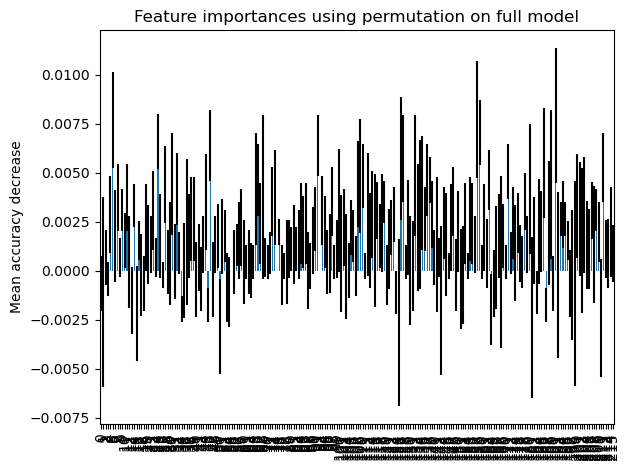

In [24]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Only with S2 data

In [25]:
X_train_reduced, y_train = nigeria_train.as_array(flatten_x=False, S2_features_only=True)
X_train_reduced_flat, y_train_flat = nigeria_train.as_array(flatten_x=True, S2_features_only=True)
print(X_train_reduced.shape, y_train.shape)
print(X_train_reduced_flat.shape, y_train_flat.shape)

X_test_reduced, y_test = nigeria_test.as_array(flatten_x=False, S2_features_only=True)
X_test_reduced_flat, y_test_flat = nigeria_test.as_array(flatten_x=True, S2_features_only=True)
print(X_test_reduced.shape, y_test.shape)
print(X_test_reduced_flat.shape, y_test_flat.shape)

(913, 12, 12) (913,)
(913, 144) (913,)
(455, 12, 12) (455,)
(455, 144) (455,)


In [26]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_reduced_flat, y_train_flat)
y_pred = rf.predict(X_test_reduced_flat)

In [27]:
roc_auc = roc_auc_score(y_test_flat, y_pred)
recall = recall_score(y_test_flat, y_pred)
precision = precision_score(y_test_flat, y_pred)
f1 = f1_score(y_test_flat, y_pred)
acc = (y_pred == y_test_flat).sum() / len(y_test_flat)

print('RF roc-auc test set:', round(roc_auc, 3))
print('RF recall test set:', round(recall, 3))
print('RF precision test set:', round(precision, 3))
print('RF f1-score test set:', round(f1, 3))
print('RF accuracy test set:', round(acc, 3))

RF roc-auc test set: 0.796
RF recall test set: 0.765
RF precision test set: 0.749
RF f1-score test set: 0.757
RF accuracy test set: 0.802


Results are about 2 decimal points better when using extra cropharvest features!

### 3. Training using Nigeria validation set as well

In [28]:
X_train_flat, y_train_flat = nigeria_train.as_array(flatten_x=True)
X_val_flat, y_val_flat = nigeria_val.as_array(flatten_x=True)
print(X_train_flat.shape, y_train_flat.shape)
print(X_val_flat.shape, y_val_flat.shape)

(913, 216) (913,)
(454, 216) (454,)


In [29]:
X_train_val_flat = np.concatenate((X_train_flat, X_val_flat))
y_train_val_flat = np.concatenate((y_train_flat, y_val_flat))
print(X_train_val_flat.shape, y_train_val_flat.shape)

(1367, 216) (1367,)


In [30]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train_val_flat, y_train_val_flat)
y_pred = rf.predict(X_test_flat)

In [31]:
roc_auc = roc_auc_score(y_test_flat, y_pred)
recall = recall_score(y_test_flat, y_pred)
precision = precision_score(y_test_flat, y_pred)
f1 = f1_score(y_test_flat, y_pred)
acc = (y_pred == y_test_flat).sum() / len(y_test_flat)

print('RF roc-auc test set:', round(roc_auc, 3))
print('RF recall test set:', round(recall, 3))
print('RF precision test set:', round(precision, 3))
print('RF f1-score test set:', round(f1, 3))
print('RF accuracy test set:', round(acc, 3))

RF roc-auc test set: 0.812
RF recall test set: 0.76
RF precision test set: 0.79
RF f1-score test set: 0.774
RF accuracy test set: 0.822


### 4. Geowiki + Nigeria training

In [173]:
class LandTypeClassificationDataset(Dataset):
    r"""
    A dataset for land-type classification data.
    Iterating through this dataset returns a tuple
    (x, y, weight), where weight is an optionally added
    geographically defined weight.

    The dataset should be called through the model - the parameters
    are defined there.
    """

    def __init__(
        self,
        subset: str,
        include_geowiki: bool,
        include_nigeria: bool,
        evaluating: bool = False,
        geowiki_dataset: Optional[GeowikiCropHarvestDataset] = None,
        nigeria_dataset: Optional[GeowikiCropHarvestDataset] = None,
    ) -> None:

        assert subset in ["training", "validation", "testing"]
        self.subset_name = subset
        self.target_country_borders = gpd.read_file(Path('../assets/nigeria_borders.shp')) # Assumes target country is Nigeria. TODO: take from geowiki_set.countries_to_weight and natural earth countries shapefiles

        # To evaluate/test. We use Nigeria dataset validation files (for dev) or testing folder (for final results)
        if (subset == "testing") or (evaluating and subset == "validation"):
            
            #print(f"Evaluating using the Nigeria dataset {subset} folder")
            # assert normalizing_dict is not None # we want to normalize our test set with the training and val data statistics 
            # self.normalizing_dict = normalizing_dict

            self.filepaths = nigeria_dataset.filepaths
            self.y_vals = nigeria_dataset.y_vals
            self.normalizing_dict = nigeria_dataset.normalizing_dict
            print(f'Number of instances in Nigeria {subset} set: {len(self.filepaths)}')

        # For training and validation
        else:
            assert (
                max(include_geowiki, include_nigeria) is True
            ), "At least one dataset must be included"

            files_and_dicts: List[Tuple[List[Path], Optional[Dict]]] = []
            datasets: Dict[str: gpd.GeoDataFrame] = dict()

            ### Grab files and normalizing dicts from each dataset ###
            if include_geowiki:
                geowiki_filepaths = geowiki_dataset.filepaths
                geowiki_y_vals = geowiki_dataset.y_vals
                geowiki_nd = geowiki_dataset.normalizing_dict
                datasets['geowiki-landcover-2017'] = geowiki_dataset.labels
                files_and_dicts.append((geowiki_filepaths, geowiki_y_vals, geowiki_nd))
                print(f'Number of instances in Geowiki {subset} set: {len(geowiki_filepaths)}')

            if include_nigeria:
                nigeria_filepaths = nigeria_dataset.filepaths
                nigeria_y_vals = nigeria_dataset.y_vals
                nigeria_nd = nigeria_dataset.normalizing_dict
                datasets['nigeria'] = nigeria_dataset.labels
                files_and_dicts.append((nigeria_filepaths, nigeria_y_vals, nigeria_nd))
                print(f'Number of instances in Nigeria {subset} set: {len(nigeria_filepaths)}')

            ### Combine the datasets ###
            self.normalizing_dict = self.adjust_normalizing_dict([(len(x[0]), x[2]) for x in files_and_dicts]) # pass on len of each dataset and their normalizing dicts

            filepaths: List[Path] = []
            y_vals: List[int] = []
            for files, y_val, nd in files_and_dicts:
                filepaths.extend(files)
                y_vals.extend(y_val)
            self.filepaths = filepaths
            self.y_vals = y_vals
            self.datasets = datasets
            print(f"Total number of files used for {subset}: {len(self.filepaths)}")

    @property
    def num_output_classes(self) -> int:
        return 1

    @property
    def num_input_features(self) -> int: 
        # assumes the first value in the tuple is x
        assert len(self.filepaths) > 0, "No files to load!"
        output_tuple = self[0]
        return output_tuple[0].shape[1] #TODO: check how this works if we do flatten the input or not (sol: index via -1)

    @property
    def num_timesteps(self) -> int:
        # assumes the first value in the tuple is x
        assert len(self.filepaths) > 0, "No files to load!"
        output_tuple = self[0]
        return output_tuple[0].shape[0]
    
    def __len__(self) -> int:
        return len(self.filepaths)

    def __getitem__(
        self, index: int
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Return the data, label, and weight tensors.
        """
        # Load up target file
        target_filepath = self.filepaths[index]
        target_file = h5py.File(target_filepath, "r")

        # Infer dataset name from path
        identifier, dataset_name = target_filepath.stem.split('_')

        # Crop probability threshold
        # --> not used, as cropharvest geowiki has hard labels anyways

        # Look up label in self.labels dict
        labels = self.datasets[dataset_name]
        row = labels.loc[labels['index'] == int(identifier)]
        assert len(row) == 1 # should be unique
        lat = row.iloc[0]['lat']
        lon = row.iloc[0]['lon']

        # Weight if point falls in Nigeria (for multiheaded LSTM)
        weight = 0 
        point = Point(lon, lat)
        if self.target_country_borders.contains(point).bool():
            weight = 1

        return (
            torch.from_numpy(self._normalize(target_file.get("array")[:])).float(),
            torch.tensor(self.y_vals[index]).float(),
            torch.tensor(weight).long(),
        )

    @staticmethod
    def adjust_normalizing_dict(
        dicts: Sequence[Tuple[int, Optional[Dict[str, np.ndarray]]]]
    ) -> Optional[Dict[str, np.ndarray]]:

        for length, single_dict in dicts:
            if single_dict is None:  # This means if the first normalizing dict (geowiki or Togo if we don't include geowiki) is missing we won't use any (we return None). #NOTE: beware of behaviour if I had more datasets like not geowiki and only use Nigeria or Togo.
                return None

        dicts = cast(Sequence[Tuple[int, Dict[str, np.ndarray]]], dicts)

        new_total = sum([x[0] for x in dicts])

        new_mean = (
            sum([single_dict["mean"] * length for length, single_dict in dicts])
            / new_total
        )

        new_variance = (
            sum(
                [
                    (single_dict["std"] ** 2 + (single_dict["mean"] - new_mean) ** 2)
                    * length
                    for length, single_dict in dicts
                ]
            )
            / new_total
        )

        return {"mean": new_mean, "std": np.sqrt(new_variance)}

    def _normalize(self, array: np.ndarray) -> np.ndarray:
        if self.normalizing_dict is None:
            return array
        else:
            return (array - self.normalizing_dict["mean"]) / self.normalizing_dict[
                "std"
            ]


In [175]:
subset = 'training'
#subset = 'validation'
#subset = 'testing'
#evaluating = False if subset == 'training' else True
evaluating = True
# Might be better to create a dictionary instead with the subset/split as keys and pass the whole dict to the class
if subset == 'training':
    geowiki_dataset = train_dataset
    nigeria_dataset = nigeria_train
elif subset == 'validation':
    geowiki_dataset = val_dataset
    nigeria_dataset = nigeria_val
else:
    geowiki_dataset = None
    nigeria_dataset = nigeria_test

combined_datasets = LandTypeClassificationDataset(
    subset = subset,
    include_geowiki = True,
    include_nigeria = True,
    evaluating = evaluating,
    geowiki_dataset = geowiki_dataset,
    nigeria_dataset = nigeria_dataset,
    )

Number of instances in Geowiki training set: 19808
Number of instances in Nigeria training set: 913
Total number of files used for training: 20721


Using validation data for training seems to worsen the results a bit!

## LSTM model

In [32]:
BANDS

['VV',
 'VH',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'temperature_2m',
 'total_precipitation',
 'elevation',
 'slope',
 'NDVI']

In [33]:
parser = ArgumentParser()

model_args = STR2MODEL["land_cover"].add_model_specific_args(parser).parse_args(args=[])
model = STR2MODEL["land_cover"](model_args)

Checking for data files


2946it [00:00, 29451.46it/s]

35599it [00:09, 3693.82it/s]


All pickle files were found!
length labels: 35599
length pickle files: 35599
length local ids: 490
Found normalizing dict normalizing_dict.pkl
Loading normalizing dict.
{'mean': array([0.19353804, 0.17112217, 0.16083624, 0.16354993, 0.18635676,
       0.25554994, 0.29061711, 0.28009877, 0.31469831, 0.10141977,
       0.0087153 , 0.22964706, 0.15255525, 0.3221835 ]), 'std': array([0.14932182, 0.15265479, 0.14360899, 0.16329558, 0.15796025,
       0.14746618, 0.15011357, 0.14306833, 0.14913972, 0.09338568,
       0.02771975, 0.1111936 , 0.09549155, 0.23958353])}
Train split
Checking for data files


35599it [00:14, 2472.21it/s]


All pickle files were found!
length labels: 28479
length pickle files: 28479
length local ids: 404
{'mean': array([0.19353804, 0.17112217, 0.16083624, 0.16354993, 0.18635676,
       0.25554994, 0.29061711, 0.28009877, 0.31469831, 0.10141977,
       0.0087153 , 0.22964706, 0.15255525, 0.3221835 ]), 'std': array([0.14932182, 0.15265479, 0.14360899, 0.16329558, 0.15796025,
       0.14746618, 0.15011357, 0.14306833, 0.14913972, 0.09338568,
       0.02771975, 0.1111936 , 0.09549155, 0.23958353])}
Val split
Checking for data files


35599it [00:04, 8203.09it/s]


All pickle files were found!
length labels: 7120
length pickle files: 7120
length local ids: 86
{'mean': array([0.19353804, 0.17112217, 0.16083624, 0.16354993, 0.18635676,
       0.25554994, 0.29061711, 0.28009877, 0.31469831, 0.10141977,
       0.0087153 , 0.22964706, 0.15255525, 0.3221835 ]), 'std': array([0.14932182, 0.15265479, 0.14360899, 0.16329558, 0.15796025,
       0.14746618, 0.15011357, 0.14306833, 0.14913972, 0.09338568,
       0.02771975, 0.1111936 , 0.09549155, 0.23958353])}
training set -> number of instances of geowiki_landcover_2017: 28479
training set -> number of instances of nigeria: 915
Total number of files used for training: 29394
Number of model parameters: 23937


In [34]:
model_args

Namespace(add_geowiki=True, add_nigeria=True, add_togo=False, alpha=10, batch_size=64, data_folder='/home/gajo/code/togo-crop-mask/notebooks/../data', geowiki_subset='world', hidden_vector_size=64, learning_rate=0.001, lstm_dropout=0.2, model_base='lstm', multi_headed=False, num_classification_layers=2, num_lstm_layers=1, probability_threshold=0.5, remove_b1_b10=True, weighted_loss_fn=False)

In [35]:
# Adjust for more input channels on cropharvest (hack to avoid changing code for experimentation)
model.input_size = X.shape[-1] # now 18 features instead of 12
model.base = STR2BASE[model.hparams.model_base](input_size=model.input_size, hparams=model.hparams) # re-initialize LSTM with correct input size

In [36]:
X_tensor = torch.from_numpy(X).to(torch.float32)

In [37]:
X.shape, X_tensor.shape

((24761, 12, 18), torch.Size([24761, 12, 18]))

In [38]:
y_pred = model.forward(X_tensor)
y_pred, y_pred.shape

(tensor([[0.5160],
         [0.5238],
         [0.5153],
         ...,
         [0.5211],
         [0.5161],
         [0.5242]], grad_fn=<SigmoidBackward0>),
 torch.Size([24761, 1]))

In [39]:
print("Without training, just random weights intialized near 0, this is what the networks predicts as \% of cropland pixels for Geowiki. Makes sense that sigmoid outputs are near 0.5 as sigmoid is 0-centered.")
(y_pred > 0.5).sum() / len(y_pred)

Without training, just random weights intialized near 0, this is what the networks predicts as \% of cropland pixels for Geowiki. Makes sense that sigmoid outputs are near 0.5 as sigmoid is 0-centered.


tensor(0.9955)

### Training

Now we need to train the LSTM model on the nigeria train set, on geowiki, on both nigeria and geowiki, while testing on the Nigeria test set. For experimentation, I can just use pytorch instead of lightning and reimplementing the `LandcCoverMapper` and `LandTypeClassificationDataset` classes.

In [40]:
max_epochs = 1000
num_workers = 8
model.hparams

"add_geowiki":               True
"add_nigeria":               True
"add_togo":                  False
"alpha":                     10
"batch_size":                64
"data_folder":               /home/gajo/code/togo-crop-mask/notebooks/../data
"geowiki_subset":            world
"hidden_vector_size":        64
"learning_rate":             0.001
"lstm_dropout":              0.2
"model_base":                lstm
"multi_headed":              False
"num_classification_layers": 2
"num_lstm_layers":           1
"probability_threshold":     0.5
"remove_b1_b10":             True
"weighted_loss_fn":          False

In [41]:
model

LandCoverMapper(
  (base): LSTM(
    (lstm): UnrolledLSTM(
      (rnn): UnrolledLSTMCell(
        (forget_gate): Sequential(
          (0): Linear(in_features=82, out_features=64, bias=True)
          (1): Sigmoid()
        )
        (update_gate): Sequential(
          (0): Linear(in_features=82, out_features=64, bias=True)
          (1): Sigmoid()
        )
        (update_candidates): Sequential(
          (0): Linear(in_features=82, out_features=64, bias=True)
          (1): Tanh()
        )
        (output_gate): Sequential(
          (0): Linear(in_features=82, out_features=64, bias=True)
          (1): Sigmoid()
        )
        (cell_state_activation): Tanh()
      )
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (global_classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [42]:
# Define dataloaders
train_dataloader = torch.utils.data.DataLoader(nigeria_train, batch_size=model.hparams["batch_size"], num_workers=num_workers, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(nigeria_val, batch_size=model.hparams["batch_size"], num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(nigeria_test, batch_size=model.hparams["batch_size"], num_workers=num_workers)

In [43]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=model.hparams["learning_rate"])
loss_fn = model.loss_function

In [44]:
# Training loop
for epoch in tqdm(range(500)):
    model.train()
    for batch in train_dataloader:
        data, labels = batch
        data = data.to(torch.float32)
        labels = labels.to(torch.float32).unsqueeze(-1)
        preds = model.forward(data)
        loss = loss_fn(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 500/500 [04:23<00:00,  1.90it/s]


In [45]:
X_test_tensor = torch.from_numpy(X_test).to(torch.float32)

In [46]:
y_pred = model.forward(X_test_tensor)

In [47]:
y_pred = (y_pred > 0.5).to(torch.int64)

In [48]:
y_pred = y_pred.detach().numpy()

In [49]:
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

print('LSTM roc-auc test set:', round(roc_auc, 3))
print('LSTM recall test set:', round(recall, 3))
print('LSTM precision test set:', round(precision, 3))
print('LSTM f1-score test set:', round(f1, 3))
print('LSTM accuracy test set:', round(acc, 3))

LSTM roc-auc test set: 0.808
LSTM recall test set: 0.814
LSTM precision test set: 0.734
LSTM f1-score test set: 0.772
LSTM accuracy test set: 0.807


Results with 50 epochs:

LSTM roc-auc test set: 0.813

LSTM recall test set: 0.798

LSTM precision test set: 0.756

LSTM f1-score test set: 0.777

LSTM accuracy test set: 0.815

Results with 100 epochs:

LSTM roc-auc test set: 0.811

LSTM recall test set: 0.809

LSTM precision test set: 0.744

LSTM f1-score test set: 0.775

LSTM accuracy test set: 0.811

Still a bit worse than RF. Also worst than corresponding resuls on the manscript (table 3; acc 0.82, f1: 0.773), slightly better f1, but worse acc, and much worse AUCROC (why?)
Need to try weighted loss fn and also multiheaded with geowiki or single headed with full geowiki but combine normalizing dicts